# Exercise Sheet 6 – Natural Language Processing with BERT

 * Deep Learning – Winter term 2020/21
 * Instructor: Alexander Ecker
 * Tutors: Max Burg, Laura Pede
 * Teaching assistants: Clara Holzhüter, Pronaya Prosun Das
 * Due date: **Tue, 09.02.21, 14:00**



### IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient

## Useful information: lecture schedule and exercise sheet deadline

The topics you will need to solve in this exercise sheet may not have been discussed in the lecture at the time we handed out this notebook. We kept the exercises rather short so you can solve them in one week and recommend that you wait until all topics have been introduced in the lecture. If you want to start right away, here are some resources that might be helpful:

- https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
- https://jalammar.github.io/illustrated-transformer/
- https://jalammar.github.io/illustrated-bert/
- https://huggingface.co/transformers/glossary.html (Glossary)

The articles that are linked in those blog posts are nice resources on background information as well.

(Figures and some explanaitions are based on the work of Jay Alammar, jalammar.github.io)

## Introduction

The aim of this exercise is to build a model that can read textual data and make predictions about the *sentiment* of that text: we will calssify each sentence as either speaking "positively" about its subject of "negatively". Our model will be based on the pre-trained deep learning model BERT. We will apply the model to the IMDB movie data set to differentiate between positive and negative reviews of a movie.



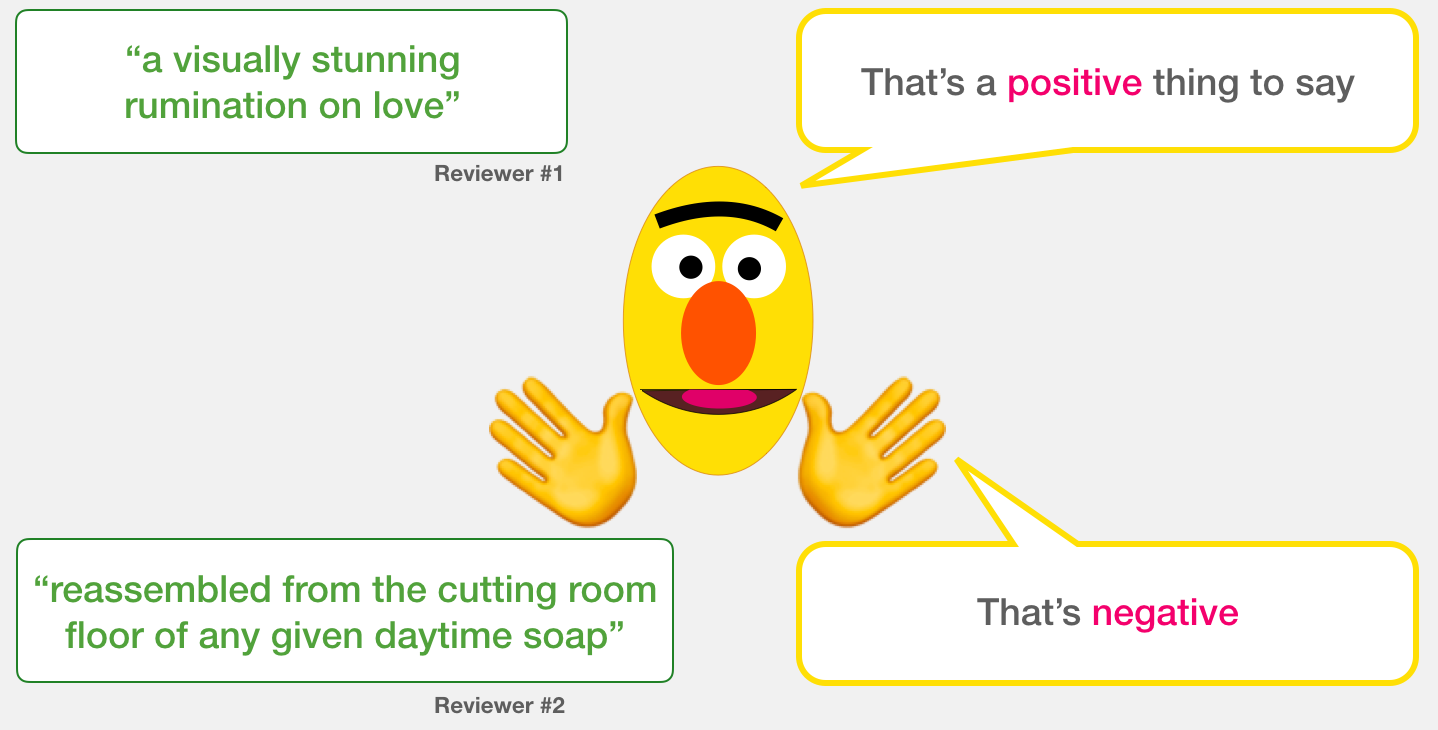

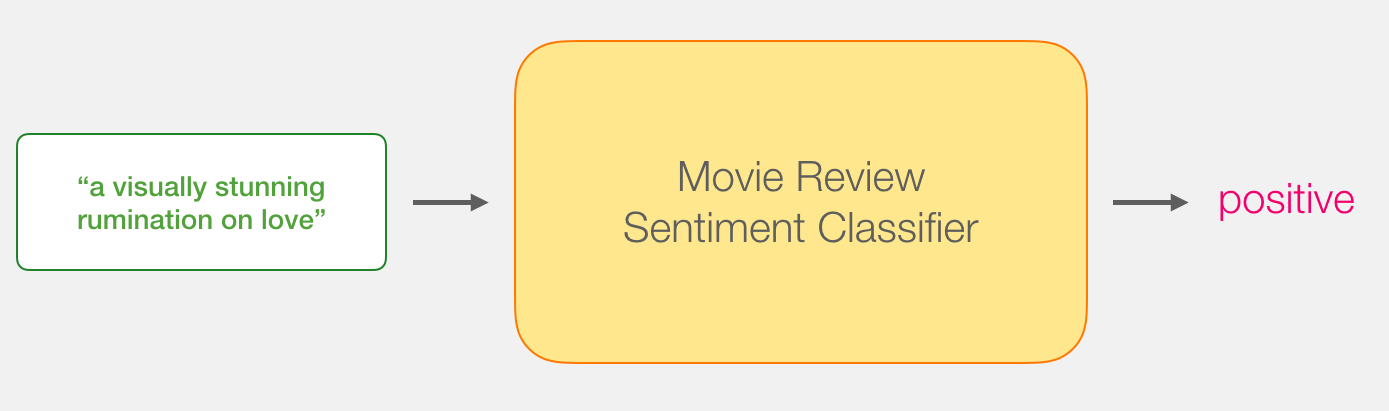

# Setup and Dataset


## Using Colab GPU for Training 

A GPU can be added by going to the menu and selecting 


```
Edit --> Notebook Settings --> Hardware accelerator --> (GPU)
```



In [102]:
import torch

# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
    device = torch.device("cuda")
    print('There is/are %d GPU(s) available.' % torch.cuda.device_count())
    print()
    print("We will use the GPU: ", torch.cuda.get_device_name(0))
    print("with the following properties: ")
    print(torch.cuda.get_device_properties(0))
else:
    print('No GPU available, training on CPU instead.')

Training on GPU.
There is/are 1 GPU(s) available.

We will use the GPU:  Tesla T4
with the following properties: 
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


## Installing the Hugging Face library 

 Next, let’s install the [transformers package from the Hugging Face library](https://huggingface.co/transformers/index.html) which will give us a Pytorch interface for working with implementations of state-of-the-art embedding layers. This library contains interfaces for  pretrained language models like BERT, XLNet, OpenAI’s GPT.


In [103]:
#!pip install transformers
# !pip install transformers==3.0.0
!pip install transformers

## Downloading datasets and creating folders

Getting the data can be done automatically or manually.

Execute the following cells and it will automatically run a Python and shell script to download datasets needed to complete this task and create data folders. *NOTE: It is not relevant for our exercise to understand this section's code*

If you are using Google Colab just execute the cells below. 
Otherwise, you might have to do the following steps by yourself:
1. Install the requirements package
1.   Create a python script named download.py and copy-paste the cell starting with `%%writefile download.py`, however, do not include that line.
2.   Create a shell script by copy-pasting the following cell starting with `%%shell` without including that line and execute it


<!-- Alternatively, you can download the [Imdb Data set](https://drive.google.com/file/d/13RliAESnCKvPA7_6PUUBYqUJB_ecMp7s/view?usp=sharing) yourself to create the required directory structure by yourself. -->

In [104]:
%%shell
pip install requests

In [105]:
%%writefile download.py
# Creates a python script named download.py to download our datasets 
# from google drive files
#
# CREDITS: [1] https://stackoverflow.com/a/39225039
#          [2] Natural Language Processing with PyTorch - Build Intelligent Language Applications Using Deep Learning - Delip Rao & Brian McMahan


import requests
def progress_bar(some_iter):
    try:
        from tqdm import tqdm
        return tqdm(some_iter)
    except ModuleNotFoundError:
        return some_iter

def download_file_from_google_drive(id, destination):
    print("Downloading {}".format(destination))

    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in progress_bar(response.iter_content(CHUNK_SIZE)):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)


if __name__ == "__main__":
    import sys
    if len(sys.argv) != 3:
        print("Usage: python download.py drive_file_id destination_file_path")
    else:
        # TAKE ID FROM SHAREABLE LINK
        file_id = sys.argv[1]
        # DESTINATION FILE ON YOUR DISK or CLOUD
        destination = sys.argv[2]
        download_file_from_google_drive(file_id, destination)


Overwriting download.py


In [106]:
cat download.py

# Creates a python script named download.py to download our datasets 
# from google drive files
#
# CREDITS: [1] https://stackoverflow.com/a/39225039
#          [2] Natural Language Processing with PyTorch - Build Intelligent Language Applications Using Deep Learning - Delip Rao & Brian McMahan


import requests
def progress_bar(some_iter):
    try:
        from tqdm import tqdm
        return tqdm(some_iter)
    except ModuleNotFoundError:
        return some_iter

def download_file_from_google_drive(id, destination):
    print("Downloading {}".format(destination))

    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in progress_bar(response.iter_content(CHUNK_SIZE)):
                if chunk: # filter o

In [107]:
%%shell
#! /bin/bash

# For each file, a download.py line is added to call the previous script
# Any additional processing on the downloaded file
HERE="$( cd "$( dirname "${BASH_SOURCE[0]}" )" && pwd )"

# IMDB Reviews Dataset
mkdir -p $HERE/data/imdb-ds
if [ ! -f $HERE/data/imdb-ds/IMDB_Dataset.npz ]; then
    python download.py 10qLP8pckM_oTs2cqN48Km-whkOBBXj4c $HERE/data/imdb-ds/IMDB_Dataset.npz
fi

# Sentiment Analysis

In [108]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel, BertConfig
import torch.nn as nn
from torch.nn import CrossEntropyLoss

## Data Pre-processing

In [109]:
# load the training data
file_name = '/content/data/imdb-ds/IMDB_Dataset.npz'
data = np.load(file_name, allow_pickle=True)
reviews, labels = data['sentences'], data['labels']

In [110]:
# use only 10% of the available dataset

reviews, _, labels, _ = train_test_split(reviews, labels, 
                                                    train_size=0.1, 
                                                    random_state=42)

print(f"Number of train labels:\n{len(labels)}")

Number of train labels:
5000


### Explore the dataset

In [111]:
# TODO show the first 10 samples together
# with their label (positive or negative review)
for i in range(10):
  print("positive" if labels[i] else "negative")
  print(reviews[i])

positive
This movie was borderline in crude humor....I utterly can not believe that these people can get away with this. Johnny Knoxville didn't cross the line...he was stomping all over it! This was better than the first...ALL THA WAY! The thing I found about the 1st movie was that the shenanigans were somewhat as if it was on the t.v. show. NOT THIS TIME!!! they completely made a 180 degree flip...the whole cast is so outstanding in what they do and not were the stunts crazy...but the music basically fit every situation...GOOD WORK!!!! When you go see this be sure to use the bathroom before going to the theater, maintain a strong stomach and rememba to not let your beverage spray out your nose....
negative
If you have seen Friends, the writing will feel very familiar. Especially the last 3 or 4 seasons of Friends often share the same comedy setups.The show is about a group of people whose connection is that they shared the same class when they were still rather young (about 10 years 

In [112]:
# TODO How many samples are included in the dataset?
print("The dataset has length of {}".format(len(reviews)))

The dataset has length of 5000


the number of positive label is 2519, and the number of nagative is 2481


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'numbers of each label')

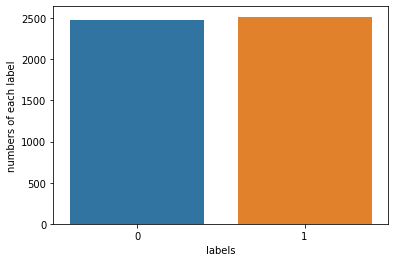

In [113]:
# TODO Is the dataset balanced?
from collections import Counter    
counter = Counter(labels)
    
print("the number of positive label is {}, and the number of nagative is {}".format(counter[1], counter[0]))

sns.countplot(labels) 
plt.xlabel("labels")
plt.ylabel("numbers of each label")


Text(0, 0.5, 'the length of each sample of dataset')

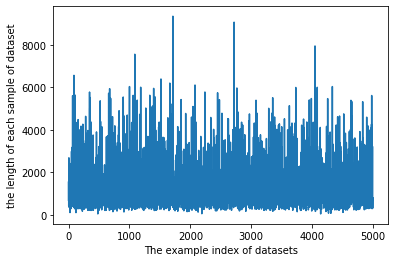

In [114]:
# TODO Visualize the length of the reviews in your dataset
lenofdata = []
for i in range(len(reviews)):
  lenofdata.append(len(reviews[i]))
plt.plot([a for a in range(len(reviews))], lenofdata)  
plt.xlabel("The example index of datasets")
plt.ylabel("the length of each sample of dataset")


## BERT: tokenization & input formatting

We will use the excellent [transformers package from the Hugging Face library](https://huggingface.co/transformers/index.html) to work with BERT.

The first step is to tokenize the reviews and bring them into the format that BERT expects. This includes

- Tokenization: break words up into words and subwords in the format BERT was trained with
- Adding special tokens: [CLS], [SEP]
- Trimming sentences to maximum length
- Padding [PAD] shorter sentences. We want BERT to process our examples batch-wise. Hence, we need to pad all lists to the same size, so we can represent the input as one 2-d array.

Documentation of `BertTokenizer`: https://huggingface.co/transformers/model_doc/bert.html#berttokenizer

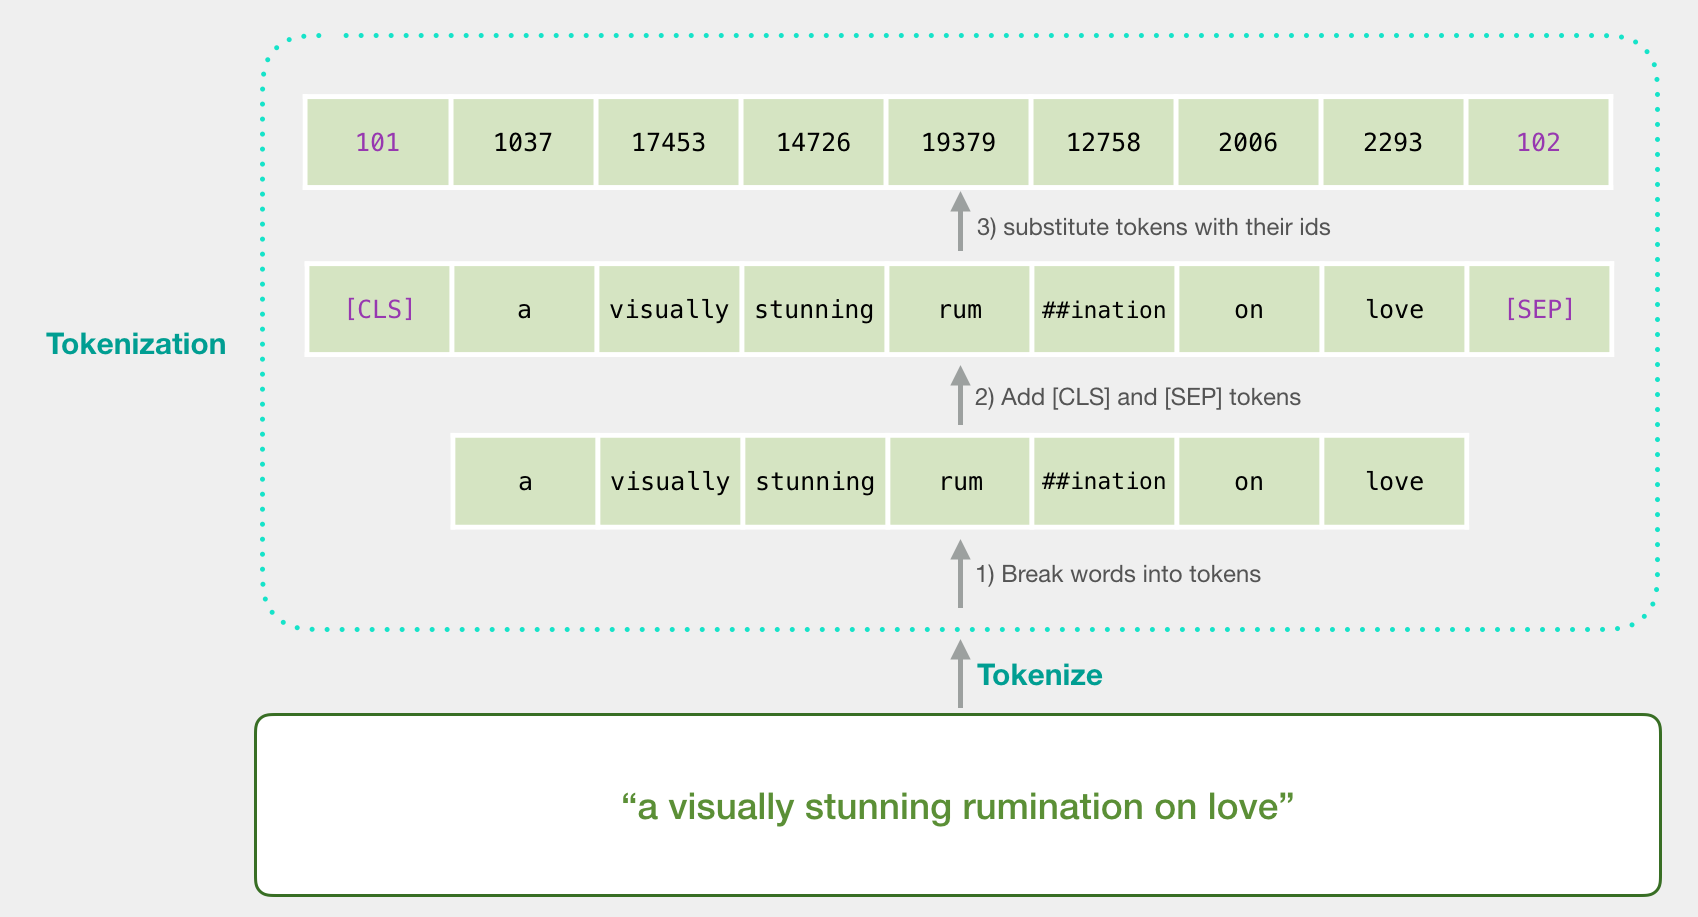

In [115]:
# Get rid of Colab warning about Tensorflow 2.0
%tensorflow_version 1.x

from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading the BERT tokenizer...')

# We will use bert-base-uncased model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

TensorFlow is already loaded. Please restart the runtime to change versions.
Loading the BERT tokenizer...


In [116]:
# Maximum length of a sequence
MAX_LEN = 128

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# Create attention masks
attention_masks = []

# For every sentence...
for review in tqdm(reviews):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad to maximum length if the sequence is shorter
    sequence = tokenizer.encode_plus(
                    review,                      # Review to encode.
                    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                    truncation=True,
                    max_length=MAX_LEN,
                    padding='max_length',
                    return_attention_mask=True)
    input_ids.append(sequence['input_ids'])
    attention_masks.append(sequence['attention_mask'])

input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)

100%|██████████| 5000/5000 [00:15<00:00, 314.29it/s]


In [117]:
# Save / load input_ids
# Mount G drive
# you only need to run the cell above once, after that you can save and load it again
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
# Save / load input_ids
import os
main_path = '/content/drive/MyDrive/Colab Notebooks'
input_ids_file = os.path.join(main_path, 'input_ids.npy')
np.save(input_ids_file, input_ids)
input_ids = np.load(input_ids_file, allow_pickle=True)[()]

In [119]:
# TODO
# Print the 25th (index 24 as indexing starts with 0 in python) example sentence
# 1) as original,
for i in range(25):
  print(reviews[i]) 



This movie was borderline in crude humor....I utterly can not believe that these people can get away with this. Johnny Knoxville didn't cross the line...he was stomping all over it! This was better than the first...ALL THA WAY! The thing I found about the 1st movie was that the shenanigans were somewhat as if it was on the t.v. show. NOT THIS TIME!!! they completely made a 180 degree flip...the whole cast is so outstanding in what they do and not were the stunts crazy...but the music basically fit every situation...GOOD WORK!!!! When you go see this be sure to use the bathroom before going to the theater, maintain a strong stomach and rememba to not let your beverage spray out your nose....
If you have seen Friends, the writing will feel very familiar. Especially the last 3 or 4 seasons of Friends often share the same comedy setups.The show is about a group of people whose connection is that they shared the same class when they were still rather young (about 10 years old I think). Now,

In [ ]:
# 2) list of token IDs, 
for i in range(25):
  print(input_ids[i])


[  101  2023  3185  2001  3675  4179  1999 13587  8562  1012  1012  1012
  1012  1045 12580  2064  2025  2903  2008  2122  2111  2064  2131  2185
  2007  2023  1012  5206 20021  2134  1005  1056  2892  1996  2240  1012
  1012  1012  2002  2001  2358 25377  2075  2035  2058  2009   999  2023
  2001  2488  2084  1996  2034  1012  1012  1012  2035 22794  2126   999
  1996  2518  1045  2179  2055  1996  3083  3185  2001  2008  1996 21882
  7088  5289  2015  2020  5399  2004  2065  2009  2001  2006  1996  1056
  1012  1058  1012  2265  1012  2025  2023  2051   999   999   999  2027
  3294  2081  1037  8380  3014 11238  1012  1012  1012  1996  2878  3459
  2003  2061  5151  1999  2054  2027  2079  1998  2025  2020  1996 28465
  4689  1012  1012  1012  2021  1996  2189   102]
[  101  2065  2017  2031  2464  2814  1010  1996  3015  2097  2514  2200
  5220  1012  2926  1996  2197  1017  2030  1018  3692  1997  2814  2411
  3745  1996  2168  4038 16437  2015  1012  1996  2265  2003  2055  1037
 

In [ ]:
# 3) it's attention mask,
for i in range(25):
  print(attention_masks[i])


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
# 4) the human readable string recreated from the token IDs, and
for i in range(25):
  print(tokenizer.convert_ids_to_tokens(input_ids[i]))

['[CLS]', 'this', 'movie', 'was', 'border', '##line', 'in', 'crude', 'humor', '.', '.', '.', '.', 'i', 'utterly', 'can', 'not', 'believe', 'that', 'these', 'people', 'can', 'get', 'away', 'with', 'this', '.', 'johnny', 'knoxville', 'didn', "'", 't', 'cross', 'the', 'line', '.', '.', '.', 'he', 'was', 'st', '##omp', '##ing', 'all', 'over', 'it', '!', 'this', 'was', 'better', 'than', 'the', 'first', '.', '.', '.', 'all', 'tha', 'way', '!', 'the', 'thing', 'i', 'found', 'about', 'the', '1st', 'movie', 'was', 'that', 'the', 'shen', '##ani', '##gan', '##s', 'were', 'somewhat', 'as', 'if', 'it', 'was', 'on', 'the', 't', '.', 'v', '.', 'show', '.', 'not', 'this', 'time', '!', '!', '!', 'they', 'completely', 'made', 'a', '180', 'degree', 'flip', '.', '.', '.', 'the', 'whole', 'cast', 'is', 'so', 'outstanding', 'in', 'what', 'they', 'do', 'and', 'not', 'were', 'the', 'stunts', 'crazy', '.', '.', '.', 'but', 'the', 'music', '[SEP]']
['[CLS]', 'if', 'you', 'have', 'seen', 'friends', ',', 'the', '

In [ ]:
# 5) the human readble, recreated string with its according attention mask applied
for i in range(25):            
  print(tokenizer.convert_tokens_to_string( tokenizer.convert_ids_to_tokens(input_ids[i])))
  

[CLS] this movie was borderline in crude humor . . . . i utterly can not believe that these people can get away with this . johnny knoxville didn ' t cross the line . . . he was stomping all over it ! this was better than the first . . . all tha way ! the thing i found about the 1st movie was that the shenanigans were somewhat as if it was on the t . v . show . not this time ! ! ! they completely made a 180 degree flip . . . the whole cast is so outstanding in what they do and not were the stunts crazy . . . but the music [SEP]
[CLS] if you have seen friends , the writing will feel very familiar . especially the last 3 or 4 seasons of friends often share the same comedy setups . the show is about a group of people whose connection is that they shared the same class when they were still rather young ( about 10 years old i think ) . now , they ' re in their mid - twenties , and they meet again on a class reunion . this is where the series starts . a typical episode deals with multiple st

### TODO

What information is stored in the attention mask? Why is it useful?

If the text is too short, the correspondings postion of attention mask is 0

## Training, Validation, Test Split

Use 10% of the dataset as validation and test set, respectively. Use the other 80% for training.

In [120]:
# TODO: Split data into training, validation, and test data
# (features, labels, and attention masks)
data = []
for i in range(len(input_ids)):
  a = []
  a.append(input_ids[i] )
  a.append(labels[i])
  a.append(attention_masks[i])
  data.append(a)
data = np.array(data)  
print(data.dtype)

random_seed = 24
from sklearn.model_selection import train_test_split#
data_train, data_test = train_test_split(data, test_size=0.2, random_state=random_seed)
data_val, data_test = train_test_split(data_test, test_size= 0.5, random_state=random_seed)

data_train = np.array(data_train)
data_test = np.array(data_test)
data_val = np.array(data_val)
print(len(data_train))
print(len(data_val))
print(len(data_test))


object
4000
500
500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [121]:
# TODO: Print out the shapes of your splitted train, validation, and test set
# Hint: your validation set should contain 500 samples. How many tokens are
# included per sample? 
print("the shape of test data is {}".format(data_train.shape))
print("the shape of validation data is {}".format(data_test.shape))
print("the shape of test data is {}".format(data_val.shape))


# (1) print the feature shapes
print("the train dataset shape is ({}, {})".format( len(data_train[:,0]), len(data_train[:,0][0])))

# (2) print the label shapes
print("the label dataset shape is {}".format(data_train[:,1].shape))

# (3) print the attention mask shapes
print("the attention dataset  shape is ({}, {})".format(len(data_train[:,2]), len(data_train[:,2][0])))


the shape of test data is (4000, 3)
the shape of validation data is (500, 3)
the shape of test data is (500, 3)
the train dataset shape is (4000, 128)
the label dataset shape is (4000,)
the attention dataset  shape is (4000, 128)


## Create DataLoader

You can use `TensorDataset`, `torch.from_numpy(...)`, and `DataLoader(...)` to create a Dataloaders for your dataset holding features, lbels and attention masks.

In [122]:
# TODO
# create Tensor datasets
# # # data = (features, labels, and attention masks) 
# features: (5000,128)
# lablels:  (5000,)
# attention masks(5000,128)
# So :data is ndarray, can't converted to tensor


def numpy2tensor(x, y):
  tmp = x[:,y]
  back = []
  for i in range(len(tmp)):
    back.append(tmp[i])
  return torch.from_numpy(np.array(back))
#for train
train_feature = numpy2tensor(data_train, 0)
train_label = numpy2tensor(data_train, 1)
train_attention_mask = numpy2tensor(data_train, 2)
#for validation
valid_feature = numpy2tensor(data_val,0)
valid_label = numpy2tensor(data_val,1)
valid_attention_mask = numpy2tensor(data_val,2)
#for test
test_feature = numpy2tensor(data_test,0)
test_label = numpy2tensor(data_test,1)
test_attention_mask = numpy2tensor(data_test,2)

In [123]:
# dataloaders
Batch_size = 10
Num_workers = 1

def trainloader (x):
  return torch.utils.data.DataLoader(
      x,
      batch_size=Batch_size,
      shuffle=True,
      num_workers=Num_workers
  )
#train
dataloader_train_feature = next(iter(trainloader(train_feature)))
dataloader_train_label = next(iter(trainloader(train_label)))
dataloader_train_attention_mask = next(iter(trainloader(train_attention_mask)))
#valid
dataloader_valid_feature = next(iter(trainloader(valid_feature)))
dataloader_valid_label = next(iter(trainloader(valid_label)))
dataloader_valid_attention_mask = next(iter(trainloader(valid_attention_mask)))
#test
dataloader_test_feature = next(iter(trainloader(test_feature)))
dataloader_test_lable = next(iter(trainloader(test_label)))
dataloader_test_attention_mask = next(iter(trainloader(test_attention_mask)))


print(dataloader_train_feature.shape)
print(dataloader_train_label.shape)
print(dataloader_train_attention_mask.shape)


# Make sure to shuffle your training data.
# Is shuffling required for the validation and test data?


torch.Size([10, 128])
torch.Size([10])
torch.Size([10, 128])



# Sentiment analysis - classification model

We will build a sentiment classifier estimating if a review is positive or negative by using transfer learning from a pre-trained BERT model, adding a readout network to BERT's sentence embeddings. For that task, we do not use the whole sentence embedding space, but only the subspace corresponding to the classification (`[CLS]`) token, including all of the 768 hidden units.



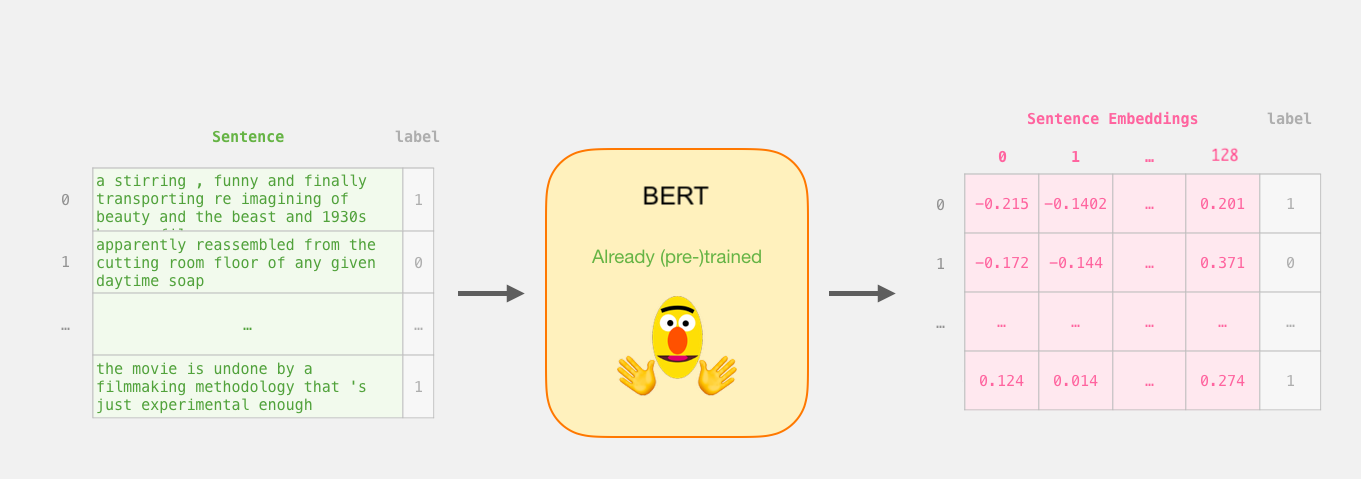

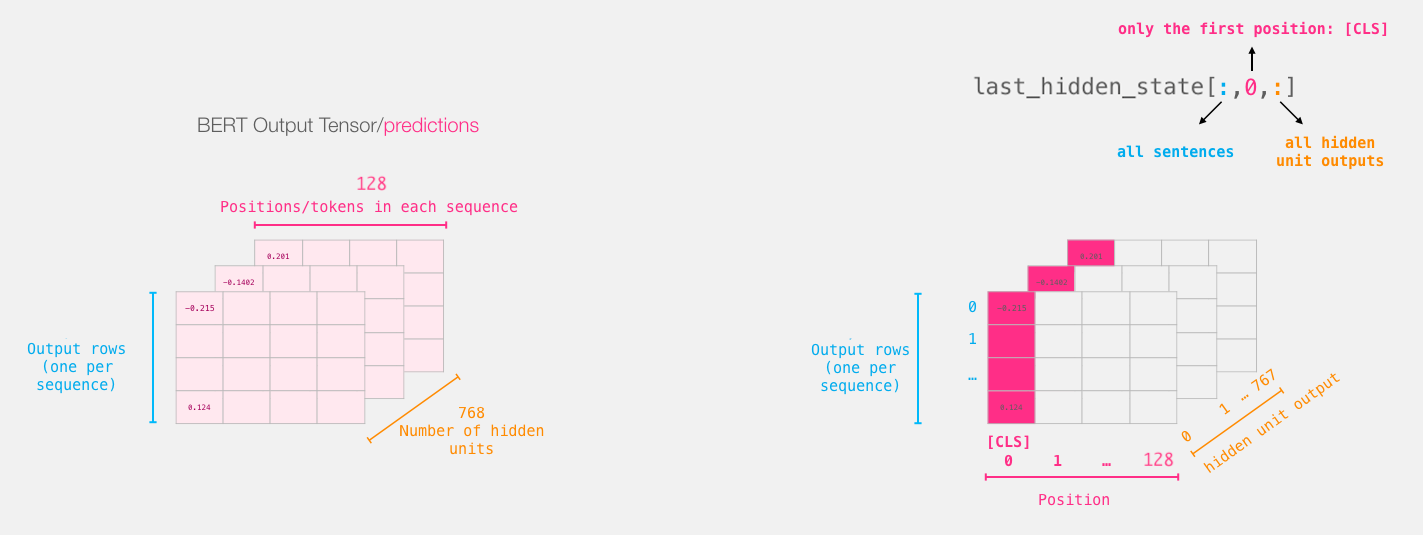

### Build the model

#### TODO


- Load a pre-trained BERT model. A good starting point for more information is the quickstart guide of the transformers library: https://huggingface.co/transformers/quickstart.html . 
- Make sure to implement the possibility to use attention masks as well. 
- Slice BERT's sentence embedding space as described above (we only want to use the `[CLS]` token for classification)
- Add two fully connected layers to that sentence embedding subspace. 
  - The first fully connected layer should have 768 output units, followed by ReLU activation function. 
  - The second (and last) fully connected layer acts as a binary classifier on top, mapping a `(BATCH_SIZE x 768)` tensor onto `(BATCH_SIZE, 2)` to predict the two classes, encoded by a one-hot vector.


*Hints:*
- Note that we used the `'bert-base-uncased'` model in the tokenizer. Use the same model here. For more information, check https://huggingface.co/transformers/pretrained_models.html
- Loading the BERT model with pre-trained model weights: 
  - https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.from_pretrained
  - https://huggingface.co/transformers/model_doc/bert.html#bertmodel
- More information on attention masks:
  - https://huggingface.co/transformers/glossary.html#attention-mask

In [124]:
# TODO model definition
class SentimentClassifier(nn.Module):
    def __init__(self, fine_tune=False, with_attention_masks=True):
        super(SentimentClassifier, self).__init__()

        self.with_attention_masks = with_attention_masks

        # TODO: BertModel as an embedding layer
       #  model_config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
       # self.bert = BertModel.from_pretrained('bert-base-uncased', config=model_config)
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.conn = nn.Linear(self.bert.config.hidden_size, 768)
       

        # Turn gradients for BertModel on/off
        # (Fine-tuning is an optional task at the end of this exercise sheet)
        self.bert.requires_grad_(fine_tune)

        # TODO: Classification layer
        self.out =  nn.Linear(768, 2)
        self.softmax = nn.Softmax()
        

    def forward(self, feature, mask):
        # TODO
        _, pooled_output = self.bert(
            input_ids = feature,
            attention_mask = mask
        )
        output = self.conn(pooled_output)
        output = self.out(output)
        return self.softmax(output)


In [126]:
model = SentimentClassifier()
model.to(device)
model(dataloader_test_feature, dataloader_test_attention_mask)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.5858, 0.4142],
        [0.6012, 0.3988],
        [0.4435, 0.5565],
        [0.5721, 0.4279],
        [0.5926, 0.4074],
        [0.5925, 0.4075],
        [0.6020, 0.3980],
        [0.5912, 0.4088],
        [0.5966, 0.4034],
        [0.5491, 0.4509]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [125]:
dataloader_train_feature = dataloader_train_feature.to(device)
dataloader_train_label = dataloader_test_lable.to(device)
dataloader_train_attention_mask = dataloader_train_attention_mask.to(device)

dataloader_valid_feature = dataloader_valid_feature.to(device)
dataloader_valid_label = dataloader_valid_label.to(device)
dataloader_valid_attention_mask = dataloader_valid_attention_mask.to(device)

dataloader_test_feature = dataloader_test_feature.to(device)
dataloader_test_lable = dataloader_test_lable.to(device)
dataloader_test_attention_mask = dataloader_test_attention_mask.to(device)
print(dataloader_test_attention_mask.shape)

torch.Size([10, 128])


## Instantiate two models

One model should use attention masks, the other should not. Initialize the models' `with_attention_mask` attribute accordingly, so you can discriminate between the two model types in your training and validation function.


In [127]:
# TODO: Instantiate the models
model_with_mask  = SentimentClassifier()
model_without_mask  = SentimentClassifier(with_attention_masks=False)

## Training and Testing

#### TODO

- Train both models. We recommend using the Adam optimizer. 
- To monitor model training, output training and validation loss and accuracy in regular intervals, at least after each epoch. Also, plot the training and validation loss and accuracy vs. epochs for both models after training.

*Hints:*

- Here, we have a classification problem with 2 classes, similar to MNIST / CIFAR-10 classification from ex. sheets 1 and 2. Which loss function is appropriate in such a setting? 
- Using a batch size of 128 and training for 5 epochs, we achieved roughly 80% acccuracy on the validation set

In [128]:
# TODO
EPOCHS = 10
lr = 2e-5
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def model_train(model, ids, labels, masks, loss_fn, optimizer, n_examples ):
  model = model.train()
  loesses = []
  correction = 0

  for id, label, mask in zip(ids, labels, masks):
    #input_ids = d["ids"]
    #target = d["lab"]
    #attention_masks = d["mask"]

    output = model(
        input_ids = id,
        attention_mask = mask
    )
    print(output.shape)

    _, preds = torch.max(output, dim =1)
    loss = loss_fn(ouput, label)

    correction += torch.sum(preds == label)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return correction.double() / n_examples, np.mean(losses)

def model_valid(model, ids, labels, masks, loss_fn, optimizer, n_examples):
  model = model.eval()
  losses = []
  correction = 0

  with torch.no_grad():
    for id, label, mask in zip(ids, labels, masks):

      outputs = model(
        input_ids=id,
        attention_mask=mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, label)

      correction += torch.sum(preds == label)
      losses.append(loss.item())

  return correction.double() / n_examples, np.mean(losses)
    


In [129]:
%%time
#with mask
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = model_train(
    model_with_mask,
    dataloader_train_feature,
    dataloader_train_label,
    dataloader_train_attention_mask,    
    loss_fn, 
    optimizer, 
    len(data_train),  
    )
  print(f'Train loss: {train_loss} accuracy: {train_acc}')

  val_acc, val_loss = eval_model(
    model_with_mask,
    dataloader_valid_feature,
    dataloader_valid_label,
    dataloader_valid_attention_mask,
    loss_fn, 
    len(data_val)
  )
  print(f'Val loss: {val_loss} accuracy: {val_acc}')
  
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


TypeError: ignored

#### TODO 
Report accuracy on the test set for both models.

In [ ]:
# TODO


#### TODO

Report accuracy on those sentences from the test set that are shorter than 75 tokens for both models

In [ ]:
# TODO 


#### TODO / Questions

- Compare the accuracy of both models on the full test set
- Compare the accuracy of both models on the subset of reviews shorter than 75 tokens
- What do you observe? How can you explain the difference that results from using the attention mask vs. not using it?

## Inference testing

This section consists of testing the models using inference testing, i.e., in our case, using other reviews to categorize them as positive or negative. 

#### TODO 
- Create a function that predicts if a text review is positive or negative
-  Choose any of your preferred movies, find a review (e.g. from imdb.com) and compare your model result against the source rating

In [ ]:
# TODO


In [ ]:
# TODO
  
test_review = "If for no other reason than to remind us who our stars were in the mid-late 70s, the Muppet Show must be returned to syndication. This was a brilliantly-written adult puppet show, with enough obvious laughs to satisfy the larvae and plenty of innuendo and hidden punch lines to absolutely mystify most adults. Fantastic. We MUST have this series back."

## [Optional] Fine-tune BERT model

(This is a non-mandatory, fully optional task)

Can you improve performance by fine-tuning BERT in addition to training the readout classifier?